Author: Tyler Chase

Date: 2017/05/18

# Model NSFW Classification

This code uses an AlexNet model to classify an image as not safe for work (nsfw) or safe for work (sfw). 

## Load Datasets

In [22]:
import tensorflow as tf
import numpy as np
import math
import timeit
import random
import pickle
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from util import import_dataset, sample_data, plot_confusion_matrix
from model import Model, lazy_property
from config import ModelConfig, TrainConfig
from data_stats import DataStats
%matplotlib inline

# Set default to auto import packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Form training, developement, and testing data sets
address = r'/home/tylerchase/CS-231N-Final-Project/data/fullData//'
address = r'../../data/fullData//'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

# Print the sizes as a sanity check
print('Train data shape: ', data.X_train.shape)
print('Train subreddit labels shape: ', data.y_train.shape)
print('Train nsfw labels shape: ', data.y_train_2.shape)
print('Validation data shape: ', data.X_val.shape)
print('Validation subreddit labels shape: ', data.y_val.shape)
print('Validation nsfw labels shape: ', data.y_val_2.shape)
print('Test data shape: ', data.X_test.shape)
print('Test subreddit labels shape: ', data.y_test.shape)
print('Test nsfw labels shape: ', data.y_test_2.shape)

Train data shape:  (25450, 128, 128, 3)
Train subreddit labels shape:  (25450,)
Train nsfw labels shape:  (25450,)
Validation data shape:  (3181, 128, 128, 3)
Validation subreddit labels shape:  (3181,)
Validation nsfw labels shape:  (3181,)
Test data shape:  (3182, 128, 128, 3)
Test subreddit labels shape:  (3182,)
Test nsfw labels shape:  (3182,)


## Determine Subreddit Statistics of Data

In [3]:
data_stats = DataStats(data, dictionary)
data_stats.sub_stats(dataSet = 'train')

EarthPorn Submissions:  1362
SkyPorn Submissions:  1359
spaceporn Submissions:  1307
MilitaryPorn Submissions:  1331
GunPorn Submissions:  1324
carporn Submissions:  1320
CityPorn Submissions:  1336
ruralporn Submissions:  969
ArchitecturePorn Submissions:  1278
FoodPorn Submissions:  1364
MoviePosterPorn Submissions:  1354
ArtPorn Submissions:  1349
RoomPorn Submissions:  1357
creepy Submissions:  1306
gonewild Submissions:  982
PrettyGirls Submissions:  1329
ladybonersgw Submissions:  917
LadyBoners Submissions:  1191
cats Submissions:  1356
dogpictures Submissions:  1359
Sanity Check Sum:  25450

Total Submissions:  25450


In [4]:
data_stats.sub_stats(dataSet = 'val')

EarthPorn Submissions:  171
SkyPorn Submissions:  175
spaceporn Submissions:  151
MilitaryPorn Submissions:  163
GunPorn Submissions:  152
carporn Submissions:  188
CityPorn Submissions:  172
ruralporn Submissions:  135
ArchitecturePorn Submissions:  138
FoodPorn Submissions:  162
MoviePosterPorn Submissions:  186
ArtPorn Submissions:  173
RoomPorn Submissions:  177
creepy Submissions:  139
gonewild Submissions:  103
PrettyGirls Submissions:  159
ladybonersgw Submissions:  122
LadyBoners Submissions:  165
cats Submissions:  159
dogpictures Submissions:  191
Sanity Check Sum:  3181

Total Submissions:  3181


## Determine NSFW Statistics of Data

In [5]:
data_stats.nsfw_stats(dataSet = 'train')

NSFW Submissions:  2164
SFW Submissions:  23286
Sanity Check Sum:  25450

Total Submissions:  25450


In [6]:
data_stats.nsfw_stats(dataSet = 'val')

NSFW Submissions:  255
SFW Submissions:  2926
Sanity Check Sum:  3181

Total Submissions:  3181


## Determine NSFW Images Per Subreddit

In [7]:
data_stats.subreddit_nsfw_stats(dataSet = 'train')

EarthPorn :  1362
NSFW:  0
SFW:  1362

SkyPorn :  1359
NSFW:  0
SFW:  1359

spaceporn :  1307
NSFW:  0
SFW:  1307

MilitaryPorn :  1331
NSFW:  4
SFW:  1327

GunPorn :  1324
NSFW:  1
SFW:  1323

carporn :  1320
NSFW:  1
SFW:  1319

CityPorn :  1336
NSFW:  0
SFW:  1336

ruralporn :  969
NSFW:  0
SFW:  969

ArchitecturePorn :  1278
NSFW:  0
SFW:  1278

FoodPorn :  1364
NSFW:  0
SFW:  1364

MoviePosterPorn :  1354
NSFW:  10
SFW:  1344

ArtPorn :  1349
NSFW:  110
SFW:  1239

RoomPorn :  1357
NSFW:  0
SFW:  1357

creepy :  1306
NSFW:  98
SFW:  1208

gonewild :  982
NSFW:  982
SFW:  0

PrettyGirls :  1329
NSFW:  0
SFW:  1329

ladybonersgw :  917
NSFW:  917
SFW:  0

LadyBoners :  1191
NSFW:  39
SFW:  1152

cats :  1356
NSFW:  1
SFW:  1355

dogpictures :  1359
NSFW:  1
SFW:  1358



In [8]:
data_stats.subreddit_nsfw_stats(dataSet = 'val')

EarthPorn :  171
NSFW:  0
SFW:  171

SkyPorn :  175
NSFW:  0
SFW:  175

spaceporn :  151
NSFW:  0
SFW:  151

MilitaryPorn :  163
NSFW:  0
SFW:  163

GunPorn :  152
NSFW:  0
SFW:  152

carporn :  188
NSFW:  0
SFW:  188

CityPorn :  172
NSFW:  0
SFW:  172

ruralporn :  135
NSFW:  0
SFW:  135

ArchitecturePorn :  138
NSFW:  0
SFW:  138

FoodPorn :  162
NSFW:  0
SFW:  162

MoviePosterPorn :  186
NSFW:  1
SFW:  185

ArtPorn :  173
NSFW:  18
SFW:  155

RoomPorn :  177
NSFW:  0
SFW:  177

creepy :  139
NSFW:  8
SFW:  131

gonewild :  103
NSFW:  103
SFW:  0

PrettyGirls :  159
NSFW:  0
SFW:  159

ladybonersgw :  122
NSFW:  122
SFW:  0

LadyBoners :  165
NSFW:  3
SFW:  162

cats :  159
NSFW:  0
SFW:  159

dogpictures :  191
NSFW:  0
SFW:  191



## Balancing the SFW/NSFW Data Content

Since safe for work SFW content takes up approximately 90% of the data here we balance the data by only considering 4 subreddits that are pictures of people. r/gonewild and r/ladybonersgw both contain mostly nsfw content and are women and men respectively. r/prettygirls and r/ladyboners both contain mostly sfw content and are women and men respectively.   

In [9]:
subreddits = ['gonewild', 'ladybonersgw', 'PrettyGirls', 'LadyBoners']
dictionary_2 = sample_data(subreddits, data, dictionary)

gonewild
posts found:  1225

ladybonersgw
posts found:  1147

PrettyGirls
posts found:  1648

LadyBoners
posts found:  1505

sanity check
posts found:  5525
length training:  4419


## Check the Subreddit Statistics of the Data Subset

In [10]:
data_stats = DataStats(data, dictionary_2)
data_stats.sub_stats(dataSet = 'train')

gonewild Submissions:  982
ladybonersgw Submissions:  917
PrettyGirls Submissions:  1329
LadyBoners Submissions:  1191
Sanity Check Sum:  4419

Total Submissions:  4419


In [11]:
data_stats.sub_stats(dataSet = 'val')

gonewild Submissions:  103
ladybonersgw Submissions:  122
PrettyGirls Submissions:  159
LadyBoners Submissions:  165
Sanity Check Sum:  549

Total Submissions:  549


## Check the NSF Statistics

In [12]:
data_stats.nsfw_stats(dataSet = 'train')

NSFW Submissions:  1938
SFW Submissions:  2481
Sanity Check Sum:  4419

Total Submissions:  4419


In [13]:
data_stats.nsfw_stats(dataSet = 'val')

NSFW Submissions:  228
SFW Submissions:  321
Sanity Check Sum:  549

Total Submissions:  549


## Determine NSFW Images Per Subreddit

In [14]:
data_stats.subreddit_nsfw_stats(dataSet = 'train')

gonewild :  982
NSFW:  982
SFW:  0

ladybonersgw :  917
NSFW:  917
SFW:  0

PrettyGirls :  1329
NSFW:  0
SFW:  1329

LadyBoners :  1191
NSFW:  39
SFW:  1152



In [15]:
data_stats.subreddit_nsfw_stats(dataSet = 'val')

gonewild :  103
NSFW:  103
SFW:  0

ladybonersgw :  122
NSFW:  122
SFW:  0

PrettyGirls :  159
NSFW:  0
SFW:  159

LadyBoners :  165
NSFW:  3
SFW:  162



## Define AlexNet model 

* 11x11 convolutional layer with 96 filters and a stride of 4
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 5x5 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2
* batch normalization


* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation
* 3x3 convolutional layer with 384 filters and a stride of 1
* ReLU activation 
* 3x3 convolutional layer with 256 filters and a stride of 1
* ReLU activation
* 3x3 max pooling with a stride of 2


* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 4096
* ReLU activation
* affine layer from 4096 to 2

In [16]:
class AlexNet(Model):
    
    def __init__(self, model_config):
        Model.__init__(self, model_config)
  
    @lazy_property
    def prediction(self):
        # define our graph (e.g. AlexNet)
        
        a1 = tf.layers.conv2d(self.X_placeholder, filters=96, kernel_size=(11,11), strides=(4,4), padding='SAME') 
        h1 = tf.nn.relu(a1)
        mp1 = tf.layers.max_pooling2d(h1, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn1 = tf.layers.batch_normalization(mp1, training=self.is_training_placeholder)
        
        a2 = tf.layers.conv2d(bn1, filters=256, kernel_size=(5,5), strides=(1,1), padding='SAME')     
        h2 = tf.nn.relu(a2)
        mp2 = tf.layers.max_pooling2d(h2, pool_size=(3,3), strides=(2,2), padding='SAME')    
        bn2 = tf.layers.batch_normalization(mp2, training=self.is_training_placeholder)              
    
        a3 = tf.layers.conv2d(bn2, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h3 = tf.nn.relu(a3)
        a4 = tf.layers.conv2d(h3, filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME')   
        h4 = tf.nn.relu(a4)
        a5 = tf.layers.conv2d(h4, filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME')    
        h5 = tf.nn.relu(a5)
        mp3 = tf.layers.max_pooling2d(h5, pool_size=(3,3), strides=(2,2), padding='SAME')  
    
        mp_flat = tf.reshape(mp3,[-1,4096])
        aff1 = tf.layers.dense(mp_flat, 4096)
        h6 = tf.nn.relu(aff1)
        aff2 = tf.layers.dense(h6, 4096)
        h7 = tf.nn.relu(aff2)
        y_out = tf.layers.dense(h7, self.config.class_size_2)
    
        return y_out     

## Train the Model

In [17]:
# Create model instance
tf.reset_default_graph()

model_config = ModelConfig(learning_rate=0.003, output = 'nsfw')
train_config = TrainConfig(num_epochs=2, minibatch_size=100, print_every=100, \
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_nsfw_classification')
model = AlexNet(model_config)

# Create session
session = tf.Session()
model.train(data, session, train_config)

---------------------------------------------------------
Batch 1/45 of epoch 1 finished in 21.124076 seconds
Epoch 1 training finished in 991.968283 seconds
train accuracy:44.0%
val accuracy:41.5%
Epoch 1 evaluation finished in 356.055326 seconds
---------------------------------------------------------
Batch 1/45 of epoch 2 finished in 21.781513 seconds
Epoch 2 training finished in 957.980422 seconds
train accuracy:52.5%
val accuracy:49.4%
Epoch 2 evaluation finished in 356.474684 seconds


## Return Loss and Accuracy History

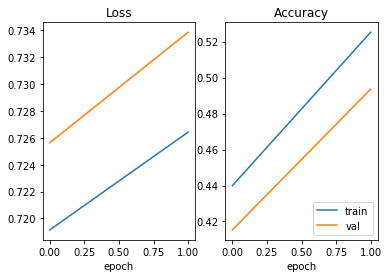

In [18]:
# Plot Loss and Accuracy
model.plot_loss_acc(data)

## Test Loading the Model

In [19]:
# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(learning_rate=0.003, output = 'nsfw')
train_config = TrainConfig(num_epochs=2, minibatch_size=100, print_every=100, \
    saver_address=r'../../subreddit_classification_parameters/', \
    save_file_name = 'AlexNet_nsfw_classification')
model = AlexNet(model_config)

# Load Saved Model
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, train_config.saver_address + train_config.save_file_name) 

# Test Model Accuracy
loss_train, acc_train = model.eval(data, session, split='train')
loss_val, acc_val = model.eval(data, session, split = 'val')

print('Training Accuracy {:3.1f}%, Vallidation Accuracy:{:3.1f}%'.format((100*acc_train), (100*acc_val)))

INFO:tensorflow:Restoring parameters from ../../subreddit_classification_parameters/AlexNet_nsfw_classification
train accuracy:52.5%
val accuracy:49.4%
Training Accuracy 52.5%, Vallidation Accuracy:49.4%


## Output Predictions for Vallidation

In [20]:
y_val_pred = session.run(model.prediction, {model.X_placeholder: data.X_val, model.y_placeholder: data.y_val_2, 
                                            model.is_training_placeholder:False})

y_val_pred = np.argmax(y_val_pred, axis = 1)

## Plot Confusion Matrix for nsfw Classification

Normalized confusion matrix


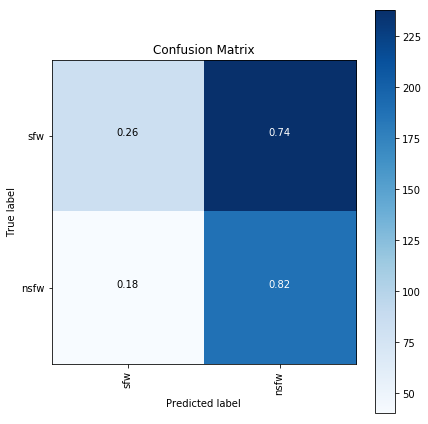

In [23]:
classes = ['sfw', 'nsfw']

conf = confusion_matrix(data.y_val_2, y_val_pred)
plot_confusion_matrix(conf, classes=classes, normalize = True)